In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Dataset

In [2]:
import torchvision

img_size = 32
num_classes = 10

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_images = torchvision.datasets.MNIST(root='./mnist_data', train=True, 
                                    download=True, transform=transform)

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
dataloader = DataLoader(mnist_images, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [5]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.init_size = 8

        self.fc = nn.Sequential(
            nn.Linear(latent_dim+num_classes, 128*8*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, padding=1),

            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),

            nn.BatchNorm2d(64,),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 
                      kernel_size=3, padding=1),            
            nn.Tanh()
        )
        
    def forward(self, z, conditional):
        # z: (batch_size, latent_dim)
        # conditional: (batch_size, num_classes)
        # inputs: (batch_size, latent_dim+num_classes)
        inputs = torch.cat([z, conditional], 1)

        # x: (batch_size, 128*8*8)
        x = self.fc(inputs)

        # x: (batch_size, 128, 8, 8)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(x)
        return img

In [14]:
class Descriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(num_classes, 1*32*32),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            nn.Conv2d(channels+1, 16, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten()
        )
        
        self.adv_layer = nn.Sequential(
            nn.Linear(128*2*2, 1), 
            nn.Sigmoid()
        )
        
    def forward(self, image, conditional):
        # image: (batch_size, 1, 32, 32)
        # conditional: (batch_size, num_classes)

        # conditional: (batch_size, 1, 32, 32)
        conditional = self.fc(conditional).view(image.size(0), 1, 32, 32)

        # x: (batch_size, 2, 32, 32)
        inputs = torch.cat([image, conditional], 1)
        x = self.model(inputs)
        validity = self.adv_layer(x)

        return validity

In [15]:
generator = Generator(latent_dim=latent_dim, num_classes=num_classes)
discriminator = Descriminator(num_classes=num_classes)

In [16]:
generator.to(device)


Generator(
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [17]:
discriminator.to(device)


Descriminator(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# 3. Training

In [18]:
import os
os.makedirs("cDCGAN_images", exist_ok=True)

save_interval = 10

In [19]:
EPOCHS = 200

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

hist = {
        "train_G_loss": [],
        "train_D_loss": [],
}

In [30]:
for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = F.one_hot(labels, num_classes).float().to(device)

        condition_labels = torch.randint(0, num_classes, (imgs.shape[0],))
        condition_labels_onehot = F.one_hot(condition_labels, num_classes).float().to(device)
        real_labels = torch.ones((imgs.shape[0], 1)).to(device)
        fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)


        # -------------------------- Train Generator --- 
        optimizer_G.zero_grad()
        
        # Noise input for Generator
        z = torch.randn((imgs.shape[0], latent_dim)).to(device)

        gen_imgs = generator(z, condition_labels_onehot)
        validity = discriminator(gen_imgs, condition_labels_onehot)
        G_loss = criterion(validity, real_labels)
        running_G_loss += G_loss.item()

        G_loss.backward()
        optimizer_G.step()


        # -------------- Train Discriminator --- 
        optimizer_D.zero_grad()

        real_validity = discriminator(real_imgs, labels)
        real_loss = criterion(real_validity, real_labels)

        fake_validity = discriminator(gen_imgs.detach(), condition_labels_onehot)
        fake_loss = criterion(fake_validity, fake_labels)
        
        D_loss = (real_loss + fake_loss) / 2
        running_D_loss += D_loss.item()

        D_loss.backward()
        optimizer_D.step()
    
    epoch_G_loss = running_G_loss / len(dataloader)
    epoch_D_loss = running_D_loss / len(dataloader)
    
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    if epoch % save_interval == 0:
        save_image(gen_imgs.data[:25], f"cDCGAN_images/epoch_{epoch}.png", nrow=5, normalize=True)

Epoch [1/200], Train G Loss: 0.8157, Train D Loss: 0.6537
Epoch [2/200], Train G Loss: 0.8120, Train D Loss: 0.6529
Epoch [3/200], Train G Loss: 1.0780, Train D Loss: 0.5532
Epoch [4/200], Train G Loss: 1.1877, Train D Loss: 0.5038
Epoch [5/200], Train G Loss: 1.3108, Train D Loss: 0.4793
Epoch [6/200], Train G Loss: 1.2535, Train D Loss: 0.5073
Epoch [7/200], Train G Loss: 1.1697, Train D Loss: 0.5309
Epoch [8/200], Train G Loss: 1.1472, Train D Loss: 0.5408
Epoch [9/200], Train G Loss: 1.1224, Train D Loss: 0.5444
Epoch [10/200], Train G Loss: 1.1366, Train D Loss: 0.5388
Epoch [11/200], Train G Loss: 1.1506, Train D Loss: 0.5223
Epoch [12/200], Train G Loss: 1.2523, Train D Loss: 0.4955
Epoch [13/200], Train G Loss: 1.3479, Train D Loss: 0.4724
Epoch [14/200], Train G Loss: 1.4185, Train D Loss: 0.4586
Epoch [15/200], Train G Loss: 1.4846, Train D Loss: 0.4447
Epoch [16/200], Train G Loss: 1.5371, Train D Loss: 0.4329
Epoch [17/200], Train G Loss: 1.5955, Train D Loss: 0.4269
Epoch 

# 4. Inference

In [31]:
%matplotlib inline
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

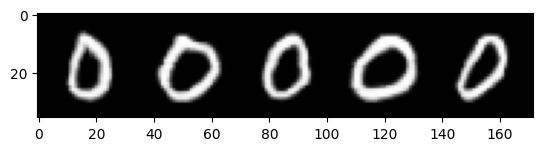

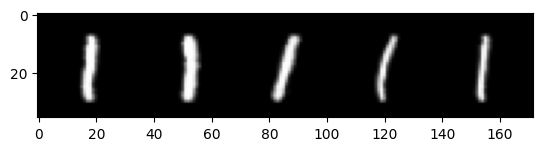

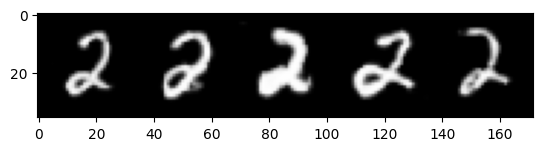

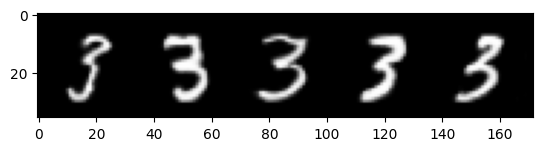

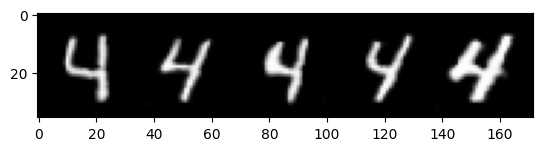

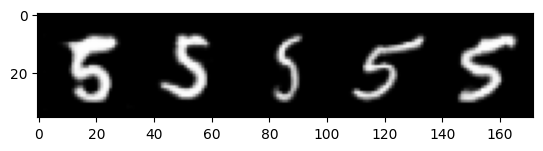

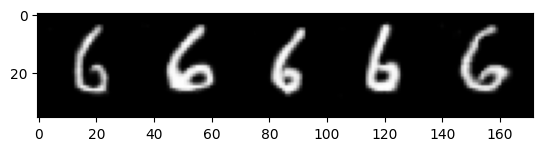

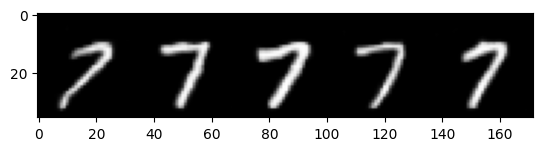

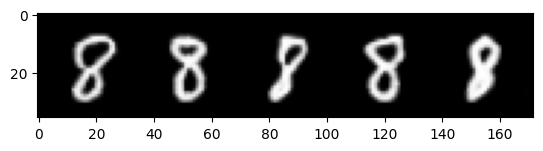

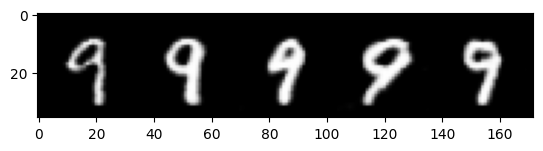

In [33]:
generator.eval()

num_sample = 5
for i in range(num_classes):
    target_class = i
    z = torch.randn((num_sample, latent_dim)).to(device)
    condition_labels = torch.tensor([target_class]*num_sample)
    condition_labels_onehot = F.one_hot(condition_labels, num_classes).float().to(device)

    gen_imgs = generator(z, condition_labels_onehot).detach().cpu()

    grid = make_grid(gen_imgs, nrow=num_sample, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()